# User-level Clustering
- Meeting 10

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pickle
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date, owner_user_id, body, parent_id
FROM answers
WHERE creation_date > '2021-09-01'
AND creation_date < '2023-09-01';
'''
df = pd.read_sql_query(query, conn)
conn.close()

In [2]:
df

,id,creation_date,owner_user_id,body,parent_id
0,69006420,2021-09-01 00:00:18.070,7332046.0,"<p>The short approach, remove python3.9 from y...",69006229
1,69006421,2021-09-01 00:00:28.823,14471093.0,"<p>open the terminal, run as administrator.</p...",68746577
2,69006422,2021-09-01 00:00:35.537,523612.0,"<p>Conceptually, <code>Base</code> has no reas...",69006293
3,69006429,2021-09-01 00:01:09.140,11269158.0,<p><code>calldata</code> is a special data loc...,68997666
4,69006430,2021-09-01 00:01:17.920,2096113.0,<p>You could do something like this if the str...,69006320
...,...,...,...,...,...
3124928,77019850,2023-08-31 23:56:07.187,313768.0,<p>Make an inner solution routine that accepts...,77013377
3124929,77019851,2023-08-31 23:56:19.123,13296852.0,<p>When you pass <code>stack[100]</code> as an...,77019825
3124930,77019853,2023-08-31 23:56:47.647,5103949.0,"<p>I had the same error, I fixed it by followi...",76922631
3124931,77019855,2023-08-31 23:57:36.797,16844882.0,"<p>In your Razor component, you can inject the...",77019829


### 1) Preprocessing

In [3]:
# erase NAs
df = df.dropna(subset=['owner_user_id'])
# Convert types
df['owner_user_id'] = df['owner_user_id'].astype(int).astype(str)
df['parent_id'] = df['parent_id'].astype(int).astype(str)
df['creation_date'] = pd.to_datetime(df['creation_date'])

# add year_month variable
df['year_month'] = df['creation_date'].dt.to_period('M')

# Get the total number of unique months
total_months = df['year_month'].nunique()
# Count the number of unique months for each user
user_month_counts = df.groupby('owner_user_id')['year_month'].nunique()
# Filter users who have written posts in every single month
users_in_every_month = user_month_counts[user_month_counts == total_months].index.tolist()

# Filtered data
df_filtered = df[df['owner_user_id'].isin(users_in_every_month)]
df_filtered

/tmp/ipykernel_1486306/3032173246.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['owner_user_id'] = df['owner_user_id'].astype(int).astype(str)
/tmp/ipykernel_1486306/3032173246.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parent_id'] = df['parent_id'].astype(int).astype(str)
/tmp/ipykernel_1486306/3032173246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,id,creation_date,owner_user_id,body,parent_id,year_month
6,69006435,2021-09-01 00:02:37.350,869736,<p>The error is correct. <code>getInputStream...,69006289,2021-09
8,69006438,2021-09-01 00:03:36.527,8690857,<p>You should not use <code>.map</code> for si...,69005880,2021-09
12,69006446,2021-09-01 00:04:33.053,16406,<p>The reason you need line B is called <a hre...,69005820,2021-09
16,69006451,2021-09-01 00:05:09.193,478884,<p>For example you could do it this way:</p>\n...,69006345,2021-09
29,69006475,2021-09-01 00:09:56.233,12957340,<p>Here is another potential solution using ti...,69005901,2021-09
...,...,...,...,...,...,...
3124903,77019800,2023-08-31 23:36:49.467,2156621,<p><code>StreamZip</code> + <code>expand</code...,77005145,2023-08
3124915,77019822,2023-08-31 23:44:48.760,209103,"<p>The <a href=""https://firebase.google.com/do...",77019651,2023-08
3124917,77019826,2023-08-31 23:46:31.700,939860,<p>You don't need a &quot;common key&quot; for...,77019724,2023-08
3124920,77019833,2023-08-31 23:49:08.340,589924,<p>The <code>sprintf</code> operator behaves l...,33897817,2023-08


### 2) Get Questions data to match parent_id to id and append tag data

In [4]:
# Import Questions data
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, tags
FROM questions
WHERE creation_date > '2020-09-01'
AND creation_date < '2023-09-01';
'''
df_tags = pd.read_sql_query(query, conn)
conn.close()

In [5]:
# Test Case
df_tags[df_tags['id'] == 69006289]

,id,tags
1629997,69006289,"[""java"", ""eclipse"", ""memory-leaks"", ""io""]"


In [6]:
df_tags['id'] = df_tags['id'].astype(str)
df_merge = pd.merge(df_filtered, df_tags, left_on = 'parent_id', right_on = 'id', how = 'left')
df_merge.drop('id_y', axis = 1, inplace = True)
df_merge = df_merge.rename(columns = {'id_x': 'id'})
df_merge

,id,creation_date,owner_user_id,body,parent_id,year_month,tags
0,69006435,2021-09-01 00:02:37.350,869736,<p>The error is correct. <code>getInputStream...,69006289,2021-09,"[""java"", ""eclipse"", ""memory-leaks"", ""io""]"
1,69006438,2021-09-01 00:03:36.527,8690857,<p>You should not use <code>.map</code> for si...,69005880,2021-09,"[""javascript"", ""arrays"", ""reactjs"", ""map-funct..."
2,69006446,2021-09-01 00:04:33.053,16406,<p>The reason you need line B is called <a hre...,69005820,2021-09,"[""c++"", ""class"", ""pointers"", ""inheritance"", ""r..."
3,69006451,2021-09-01 00:05:09.193,478884,<p>For example you could do it this way:</p>\n...,69006345,2021-09,"[""excel"", ""vba"", ""parsing"", ""offset""]"
4,69006475,2021-09-01 00:09:56.233,12957340,<p>Here is another potential solution using ti...,69005901,2021-09,"[""r""]"
...,...,...,...,...,...,...,...
437024,77019800,2023-08-31 23:36:49.467,2156621,<p><code>StreamZip</code> + <code>expand</code...,77005145,2023-08,"[""dart""]"
437025,77019822,2023-08-31 23:44:48.760,209103,"<p>The <a href=""https://firebase.google.com/do...",77019651,2023-08,"[""javascript"", ""firebase"", ""next.js"", ""server-..."
437026,77019826,2023-08-31 23:46:31.700,939860,<p>You don't need a &quot;common key&quot; for...,77019724,2023-08,"[""sql"", ""postgresql"", ""join""]"
437027,77019833,2023-08-31 23:49:08.340,589924,<p>The <code>sprintf</code> operator behaves l...,33897817,2023-08,NaN


### 3) Tag Clustering
- 3-1. Aggregate tags of each user.
- 3-2. One-hot encoding of tags
- 3-2. Cluster users based on the usage of tags.

In [7]:
# Tags Preprocessing
df_merge['tags'] = df_merge['tags'].str.replace('[\["\]]', '', regex=True)
df_merge['tags'] = df_merge['tags'].str.replace('c#','Csharp')
df_merge['tags'] = df_merge['tags'].str.replace('c++','Cpp')
df_merge['tags'] = df_merge['tags'].str.replace('.','DOT')
df_merge['tags'] = df_merge['tags'].str.replace('><',' ')
df_merge['tags'] = df_merge['tags'].str.replace('>','')
df_merge['tags'] = df_merge['tags'].str.replace('-','')
df_merge['tags'] = df_merge['tags'].str.replace('"', '')

#df_merge = df_merge.reset_index(drop = True)
#df_merge['tags'] = df_merge['tags'].str.replace(',', ' ')
#df_merge['tags'] = df_merge['tags'].str.split() 

In [8]:
df_merge.iloc[26:27,:]

,id,creation_date,owner_user_id,body,parent_id,year_month,tags
26,69007016,2021-09-01 02:02:29.327,10669010,<p>simply change the checkbox value attribute ...,69006745,2021-09,"javascript, html, jquery"


In [9]:
# 3-1 Complete
new_merge = df_merge.groupby('owner_user_id')[['body', 'tags']].agg(lambda x: ', '.join(map(str,x))).reset_index()
new_merge

,owner_user_id,body,tags
0,10008173,<p>Since you already know the location on the ...,"docker, filesystems, docker, express, dockerfi..."
1,10112124,"<p>Perhaps I'm reading the question wrong, but...","angular, authentication, rxjs, ngrx, ngrxentit..."
2,10138734,<blockquote>\n<p>What happens to BTREE index w...,"mysql, rubyonrails, ruby, railsmigrations, mys..."
3,10140124,<p>You are using multiple <code>should</code> ...,"elasticsearch, javascript, ifstatement, boolea..."
4,10157127,<p>Home you can play with style and design key...,"flutter, flutterlayout, flutterdependencies, f..."
...,...,...,...
790,9952196,"<p>In standard SQL, double quotes are used to ...","sqlite, linux, bash, shell, sed, linux, bash, ..."
791,9957710,<p>Your code is spending some time filling the...,"arrays, struct, julia, arrays, julia, multithr..."
792,99692,<p>Here is a version of the first function wit...,"rust, rust, enums, io, rust, rust, lifetime, o..."
793,9971759,<p>Hints work in the following way:</p>\n<ul>\...,"python, ortools, python, constraints, nonlinea..."


In [10]:
# 3-2 One-hot encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(new_merge['tags'].apply(lambda x: x.split(', ')))

In [11]:
tags_encoded_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)
tags_encoded_df.reset_index(inplace = True)
df_encoded = pd.concat([new_merge, tags_encoded_df], axis = 1)
df_encoded

,owner_user_id,body,tags,index,128bit,12factor,16bit,2048,234tree,23tree,...,zuora,zurbfoundation,zustand,zuulci,zwave,zwcad,zxing,zynq,zynqultrascale+,zypper
0,10008173,<p>Since you already know the location on the ...,"docker, filesystems, docker, express, dockerfi...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10112124,"<p>Perhaps I'm reading the question wrong, but...","angular, authentication, rxjs, ngrx, ngrxentit...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10138734,<blockquote>\n<p>What happens to BTREE index w...,"mysql, rubyonrails, ruby, railsmigrations, mys...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10140124,<p>You are using multiple <code>should</code> ...,"elasticsearch, javascript, ifstatement, boolea...",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10157127,<p>Home you can play with style and design key...,"flutter, flutterlayout, flutterdependencies, f...",4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,9952196,"<p>In standard SQL, double quotes are used to ...","sqlite, linux, bash, shell, sed, linux, bash, ...",790,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
791,9957710,<p>Your code is spending some time filling the...,"arrays, struct, julia, arrays, julia, multithr...",791,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,99692,<p>Here is a version of the first function wit...,"rust, rust, enums, io, rust, rust, lifetime, o...",792,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
793,9971759,<p>Hints work in the following way:</p>\n<ul>\...,"python, ortools, python, constraints, nonlinea...",793,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_encoded.owner_user_id.nunique()

795

In [13]:
df_encoded['docker']

0      1
1      0
2      0
3      0
4      0
      ..
790    0
791    1
792    1
793    0
794    1
Name: docker, Length: 795, dtype: int64

In [41]:
# 1개밖에 없는 컬럼 삭제.
tb = pd.DataFrame(df_encoded.iloc[:,4:].sum()).reset_index()
tb.columns = ['tag', 'val']
col_del = list(tb[tb['val'] == 1].tag)
df_encoded.drop(columns = col_del, inplace = True)
df_encoded

,owner_user_id,body,tags,index,128bit,16bit,2048,256color,2d,2dgames,...,zsh,zshalias,zshcompletion,zshrc,zstack,zstandard,zstd,zustand,zxing,zynq
0,10008173,<p>Since you already know the location on the ...,"docker, filesystems, docker, express, dockerfi...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10112124,"<p>Perhaps I'm reading the question wrong, but...","angular, authentication, rxjs, ngrx, ngrxentit...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10138734,<blockquote>\n<p>What happens to BTREE index w...,"mysql, rubyonrails, ruby, railsmigrations, mys...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10140124,<p>You are using multiple <code>should</code> ...,"elasticsearch, javascript, ifstatement, boolea...",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10157127,<p>Home you can play with style and design key...,"flutter, flutterlayout, flutterdependencies, f...",4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,9952196,"<p>In standard SQL, double quotes are used to ...","sqlite, linux, bash, shell, sed, linux, bash, ...",790,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
791,9957710,<p>Your code is spending some time filling the...,"arrays, struct, julia, arrays, julia, multithr...",791,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,99692,<p>Here is a version of the first function wit...,"rust, rust, enums, io, rust, rust, lifetime, o...",792,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
793,9971759,<p>Hints work in the following way:</p>\n<ul>\...,"python, ortools, python, constraints, nonlinea...",793,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Delete columns that only appeared in one user or appeared in two users
df_test = df_encoded.iloc[:,4:].replace(0, np.nan)
tb2 = pd.DataFrame(df_test.isna().sum()).reset_index()
tb2.columns = ['tag', 'val']
col_del2 = list(tb2[tb2['val'] >= 792].tag)
df_encoded.drop(columns = col_del2, inplace = True)
df_encoded

,owner_user_id,body,tags,index,16bit,2d,2dgames,32bit,32bit64bit,3d,...,zoneddatetime,zoo,zooming,zoomsdk,zscore,zsh,zshrc,zstd,zustand,zxing
0,10008173,<p>Since you already know the location on the ...,"docker, filesystems, docker, express, dockerfi...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10112124,"<p>Perhaps I'm reading the question wrong, but...","angular, authentication, rxjs, ngrx, ngrxentit...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10138734,<blockquote>\n<p>What happens to BTREE index w...,"mysql, rubyonrails, ruby, railsmigrations, mys...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10140124,<p>You are using multiple <code>should</code> ...,"elasticsearch, javascript, ifstatement, boolea...",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10157127,<p>Home you can play with style and design key...,"flutter, flutterlayout, flutterdependencies, f...",4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,9952196,"<p>In standard SQL, double quotes are used to ...","sqlite, linux, bash, shell, sed, linux, bash, ...",790,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
791,9957710,<p>Your code is spending some time filling the...,"arrays, struct, julia, arrays, julia, multithr...",791,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,99692,<p>Here is a version of the first function wit...,"rust, rust, enums, io, rust, rust, lifetime, o...",792,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
793,9971759,<p>Hints work in the following way:</p>\n<ul>\...,"python, ortools, python, constraints, nonlinea...",793,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
from sklearn.cluster import KMeans
X = df_encoded.iloc[:, 4:]
K = 10
kmeans = KMeans(n_clusters = K, random_state = 0)
kmeans.fit(X)
labels = kmeans.labels_

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [107]:
df_encoded['cluster'] = labels
df_encoded

,owner_user_id,body,tags,index,16bit,2d,2dgames,32bit,32bit64bit,3d,...,zoo,zooming,zoomsdk,zscore,zsh,zshrc,zstd,zustand,zxing,cluster
0,10008173,<p>Since you already know the location on the ...,"docker, filesystems, docker, express, dockerfi...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10112124,"<p>Perhaps I'm reading the question wrong, but...","angular, authentication, rxjs, ngrx, ngrxentit...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,10138734,<blockquote>\n<p>What happens to BTREE index w...,"mysql, rubyonrails, ruby, railsmigrations, mys...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,10140124,<p>You are using multiple <code>should</code> ...,"elasticsearch, javascript, ifstatement, boolea...",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,10157127,<p>Home you can play with style and design key...,"flutter, flutterlayout, flutterdependencies, f...",4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,9952196,"<p>In standard SQL, double quotes are used to ...","sqlite, linux, bash, shell, sed, linux, bash, ...",790,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
791,9957710,<p>Your code is spending some time filling the...,"arrays, struct, julia, arrays, julia, multithr...",791,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
792,99692,<p>Here is a version of the first function wit...,"rust, rust, enums, io, rust, rust, lifetime, o...",792,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
793,9971759,<p>Hints work in the following way:</p>\n<ul>\...,"python, ortools, python, constraints, nonlinea...",793,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [108]:
df_encoded.groupby('cluster').size()

cluster
0     21
1     68
2     42
3     35
4    176
5    368
6     50
7     28
8      6
9      1
dtype: int64

In [120]:
df_encoded[df_encoded['cluster'] ==5]

,owner_user_id,body,tags,index,16bit,2d,2dgames,32bit,32bit64bit,3d,...,zoo,zooming,zoomsdk,zscore,zsh,zshrc,zstd,zustand,zxing,cluster
1,10112124,"<p>Perhaps I'm reading the question wrong, but...","angular, authentication, rxjs, ngrx, ngrxentit...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5,10195153,"<p><a href=""https://www.djangoproject.com/down...","mysql, django, django, djangomodels, mariadb, ...",5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,10197418,<p>The problem here is the assumption that <co...,"python, datetime, python, datetime, python, da...",6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10,10308336,<p>The <code>Build Action</code> of your <code...,"android, xamarinDOTandroid, androidmanifest, a...",10,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,5
12,10347145,<p>Why not changing this...</p>\n<pre><code>@m...,"css, twitterbootstrap, html, css, twitterboots...",12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,9862669,<p>Go System Preferences --&gt; Security &amp;...,"macos, applescript, javascript, applescript, m...",785,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
786,9922,"<p>This is covered <a href=""https://learn.micr...","azure, azureadb2c, azureadb2ccustompolicy, azu...",786,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
788,9937026,"<p>Here's a solution based on\n<a href=""https:...","sql, sqlserver, tsql, sql, hiveql, sql, sqlser...",788,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
792,99692,<p>Here is a version of the first function wit...,"rust, rust, enums, io, rust, rust, lifetime, o...",792,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5


In [123]:
user_cluster = pd.DataFrame({'owner_user_id': df_encoded['owner_user_id'],
                             'label': df_encoded['cluster']})
user_cluster

,owner_user_id,label
0,10008173,0
1,10112124,5
2,10138734,2
3,10140124,1
4,10157127,1
...,...,...
790,9952196,4
791,9957710,4
792,99692,5
793,9971759,5


In [125]:
# Save Data
#import pickle
#with open(file = 'user_cluster.pickle', mode = 'wb') as file:
#    pickle.dump(user_cluster, file)

### Extra) Elbow Method

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

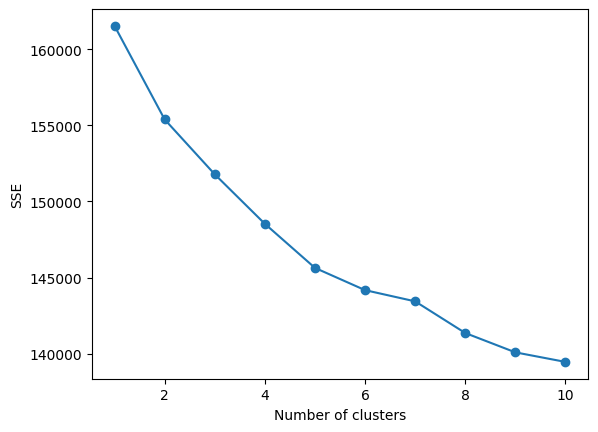

In [122]:
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1,11), sse, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

### LSM 
- total 794 users

In [137]:
# merge og dataframe with label.
df_analysis = df_merge.groupby(['owner_user_id', 'year_month'])['body'].agg(lambda x: ', '.join(map(str,x))).reset_index()
df_analysis = pd.merge(df_analysis, user_cluster, on = 'owner_user_id', how = 'left')
# erase users in the label 9.
df_analysis = df_analysis[df_analysis['label'] != 9]
df_analysis

,owner_user_id,year_month,body,label
0,10008173,2021-09,<p>Since you already know the location on the ...,0
1,10008173,2021-10,<p>That <code>ENTRYPOINT</code> line doesn't f...,0
2,10008173,2021-11,<p>A Docker container only runs one process. ...,0
3,10008173,2021-12,<p>Connections between containers (over the Do...,0
4,10008173,2022-01,<p>You can use the Docker image name (<code>do...,0
...,...,...,...,...
19075,997358,2023-04,<p>To avoid various inefficiencies in your pro...,4
19076,997358,2023-05,<p>If you want an expression which is guarante...,4
19077,997358,2023-06,<p>How to optimize? Since you don't seem to h...,4
19078,997358,2023-07,"<p>Since the <a href=""/questions/tagged/jq"" cl...",4


In [143]:
# Monthly aggregate for each user
year_month = list(df_analysis['year_month'].unique().astype('str')) # get unique year_month
# Save individual body data into separate md file.
for i in range(len(year_month)):
    output_directory = f'/data1/StackOverflow/_Robustness/UserCluster/data/{year_month[i]}'
    os.makedirs(output_directory, exist_ok=True)
    data = df_analysis[df_analysis['year_month'] == year_month[i]]
    for index, row in data.iterrows():
        user_filename = f"{output_directory}/user_{row['owner_user_id']}.md"
        with open(user_filename, 'w') as md_file:
            md_file.write(f"## User {row['owner_user_id']}\n")
            md_file.write(row['body'] + '\n\n')
    print(f"Data has been saved to individual md files in the '{output_directory}' directory.")

Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2021-09' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2021-10' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2021-11' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2021-12' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2022-01' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2022-02' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2022-03' directory.
Data has been saved to individual md files in the '/data1/StackOverflow/_Robustness/UserCluster/data/2022-04' directory.
Data has been saved to individua

In [144]:
# save year_month pickle
#with open(f'year_month.pickle', 'wb') as fw:
#    pickle.dump(year_month, fw)

In [145]:
# save df_analysis pickle
#with open(f'df_analysis.pickle', 'wb') as fw:
#    pickle.dump(df_analysis, fw)

### HERE, use separate py file for lsm computation.
- compute.py

In [ ]:
folder_path = '/data1/StackOverflow/language-style-matching-python/Final_pickle'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)
file_list = sorted(file_list)

# Filter only pickle files
pickle_files = [file for file in file_list if file.endswith('.pickle')]

# Iterate through each pickle file and load it into a separate object
loaded_objects = []
for pickle_file in pickle_files:
    file_path = os.path.join(folder_path, pickle_file)
    file_name = os.path.splitext(pickle_file)[0]
    
    with open(file_path, 'rb') as f:
        loaded_object = pickle.load(f)
        selected_indices = list(range(0, len(loaded_object), 308)) # indices of every 167 rows.
        loaded_object = loaded_object.iloc[selected_indices]
        loaded_object['year_month'] = file_name # add year_month value.
        loaded_objects.append(loaded_object)

### Triple Difference Setup
- Compute average similarity score for each cluster monthly.
- Make analysis table with folliwng columns: year_month, cluster, LSM Score
- Add techiness, T_d, P_t

In [140]:
lsm = pd.read_csv('/data1/StackOverflow/diff_in_diff/lsm_did2_modified.csv')
lsm

,User,year_month,Similarity_toAvg,T_d,P_t,ln_y
0,248823,2021-09,0.172053,0,0,-1.759955
1,12634230,2021-09,0.176826,0,0,-1.732590
2,3440745,2021-09,0.180247,0,0,-1.713425
3,775806,2021-09,0.175294,0,0,-1.741289
4,65863,2021-09,0.167398,0,0,-1.787383
...,...,...,...,...,...,...
3715,9450991,2023-08,0.185786,1,1,-1.683162
3716,584518,2023-08,0.190578,1,1,-1.657693
3717,10157127,2023-08,0.184107,1,1,-1.692236
3718,939557,2023-08,0.204949,1,1,-1.584994


In [142]:
df_final_pre3 = pd.read_csv('/data1/StackOverflow/_Robustness/Techiness/df_final_pre5.csv')
df_final_pre3

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,...,ln_entropy,year_month,numUser,ln_numUser,comments,AnsPerQ,CommentsPerQ,ln_comments,ln_AnsPerQ,ln_CommentsPerQ
0,2021-09-01,0,0,9,0,0.525040,7.298398,1213.0,1029.0,7.100852,...,1.987655,2021-09,22317,10.013104,2291,1.164056,1.888706,7.736744,0.151911,0.635892
1,2021-09-01,0,0,9,1,0.412791,7.399966,401.0,225.0,5.993961,...,2.001475,2021-09,7820,8.964440,938,1.032419,2.339152,6.843750,0.031905,0.849789
2,2021-09-01,0,0,9,3,0.490224,7.231138,394.0,250.0,5.976351,...,1.978396,2021-09,7714,8.950792,841,1.010152,2.134518,6.734592,0.010101,0.758241
3,2021-09-01,0,0,9,4,0.439161,7.709924,368.0,305.0,5.908083,...,2.042508,2021-09,7720,8.951570,1365,1.141304,3.709239,7.218910,0.132172,1.310827
4,2021-09-01,0,0,9,5,0.461350,7.043218,378.0,258.0,5.934894,...,1.952065,2021-09,7509,8.923858,569,1.190476,1.505291,6.343880,0.174353,0.408986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469,2023-08-31,1,1,8,9,0.541652,4.639900,31.0,16.0,3.433987,...,1.534693,2023-08,510,6.234411,47,0.612903,1.516129,3.850148,-0.489548,0.416160
10470,2023-08-31,1,1,8,11,0.476285,4.175869,18.0,12.0,2.890372,...,1.429322,2023-08,343,5.837730,22,0.666667,1.222222,3.091042,-0.405465,0.200671
10471,2023-08-31,1,1,8,13,0.421145,5.528088,29.0,18.0,3.367296,...,1.709842,2023-08,630,6.445720,39,0.413793,1.344828,3.663562,-0.882389,0.296266
10472,2023-08-31,1,1,8,15,0.307775,2.947703,5.0,4.0,1.609438,...,1.081026,2023-08,122,4.804021,2,0.600000,0.400000,0.693147,-0.510826,-0.916291
